# Build a Generative Adversarial Network (GAN) for generating fake images using PyTorch and MNIST

In [2]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configurations

In [4]:
device = 'cpu' # this will be used to transfer images to GPU device : image = image.to(device)
batch_size = 128
noise_dim = 64

# optimizers patameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 50


# Load MNIST Dataset

In [6]:
from torchvision import datasets, transforms as T

In [10]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)  # changing the images to torch tensors
])

In [12]:
trainset = datasets.MNIST('MNIST', download = True, train = True, transform = train_augs)

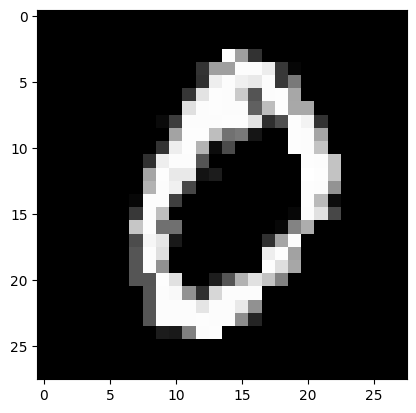

In [14]:
image, label = trainset[1]
plt.imshow(image.squeeze(), cmap = 'gray')

In [16]:
print("total images present in trainset are: ", len(trainset))

total images present in trainset are:  60000


# Load Dataset Into Batches

In [19]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [21]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle = True)
print("total number of batches in tarinloader: ", len(trainloader))

total number of batches in tarinloader:  469


In [23]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [25]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

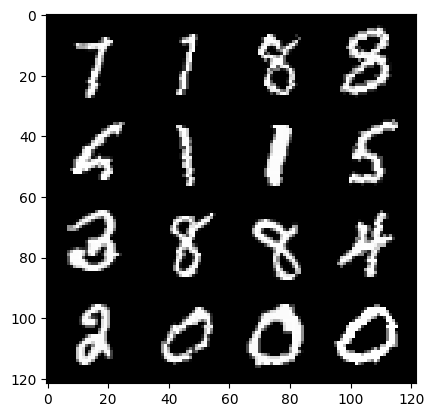

In [27]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

Discriminator Network is a simple binary classifier which classifies whether a given image is real or fake.

In [31]:
#In case if torch summary is not installed

!pip install torchsummary

In [33]:
from torch import nn
from torchsummary import summary

```mermaid
flowchart TD
    A["Input (bs, 1, 28, 28)"] --> B["Conv2D in=1, out=16, kernel=3x3, stride=2 (bs,16,13,13)"]
    B --> C["BatchNorm2D (bs,16,13,13)"]
    C --> D["LeakyReLU (bs,16,13,13)"]
    D --> E["Conv2D in=16, out=32, kernel=5x5, stride=2 (bs,32,5,5)"]
    E --> F["BatchNorm2D (bs,32,5,5)"]
    F --> G["LeakyReLU (bs,32,5,5)"]
    G --> H["Conv2D in=32, out=64, kernel=5x5, stride=2 (bs,64,1,1)"]
    H --> I["BatchNorm2D (bs,64,1,1)"]
    I --> J["LeakyReLU (bs,64,1,1)"]
    J --> K["Flatten (bs,64)"]
    K --> L["Linear in=64, out=1 (bs,1)"]

```

In [35]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [37]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [39]:
D = Discriminator()
D.to(device)
summary(D, input_size= (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

```mermaid
flowchart TD
    A["Input (bs, z_dim=64)"] --> B["Reshape to (bs, z_dim, 1, 1)"]
    B --> C["ConvTranspose2D in=z_dim, out=256, kernel=3x3, stride=2 (bs,256,3,3)"]
    C --> D["BatchNorm2D (bs,256,3,3)"]
    D --> E["ReLU (bs,256,3,3)"]
    E --> F["ConvTranspose2D in=256, out=128, kernel=4x4, stride=1 (bs,128,6,6)"]
    F --> G["BatchNorm2D (bs,128,6,6)"]
    G --> H["ReLU (bs,128,6,6)"]
    H --> I["ConvTranspose2D in=128, out=64, kernel=3x3, stride=2 (bs,64,13,13)"]
    I --> J["BatchNorm2D (bs,64,13,13)"]
    J --> K["ReLU (bs,64,13,13)"]
    K --> L["ConvTranspose2D in=64, out=1, kernel=4x4, stride=2 (bs,1,28,28)"]
    L --> M["Tanh (bs,1,28,28)"]


```

In [41]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [43]:
class Generator(nn.Module):

    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)

        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

    def forward(self, r_noise_vec):

        #(bs, noise_dim) -> (bs, noise_dim, 1, 1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        return x4


In [45]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [47]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [49]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [51]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss
def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [53]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas=(beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93259805..0.9963994].


Epoch: 1 | D_loss: 0.6821492647311327 | G_loss: 0.6937397427396226


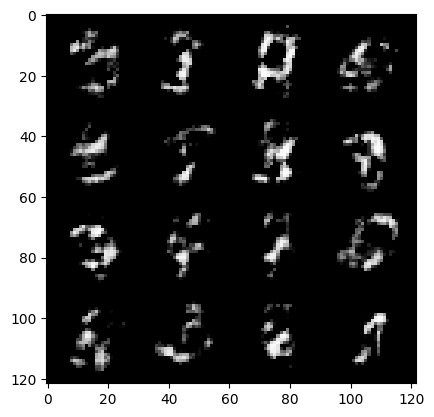

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.6746604553163688 | G_loss: 0.7153165693730433


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.6383746474790675 | G_loss: 0.7550161635951955


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.61365925058373 | G_loss: 0.7841298976686718


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.6070807970154768 | G_loss: 0.8032563332555644


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.6072612445491717 | G_loss: 0.8149468819978141


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.6182153790490206 | G_loss: 0.8110897397435805


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.6277272804205352 | G_loss: 0.8074207486374292


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.6277187963538586 | G_loss: 0.8150996911500309


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.6340645260648179 | G_loss: 0.8088476884085486


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.6413076575885195 | G_loss: 0.8019148802706427


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.6455642976232175 | G_loss: 0.796765707957465


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.649542687671271 | G_loss: 0.7926833287739297


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.6510995646783793 | G_loss: 0.7890516708908814


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.6531727645697116 | G_loss: 0.7869215584767144


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.6552423095143934 | G_loss: 0.7845949008266555


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.655439182131021 | G_loss: 0.7835446652064699


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.6558587098680834 | G_loss: 0.7846749593962484


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.6570108855711118 | G_loss: 0.7854194375497701


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.6564453019262123 | G_loss: 0.7830129490732384


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 21 | D_loss: 0.6565285379698536 | G_loss: 0.7836346977046812


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 22 | D_loss: 0.6569781383471702 | G_loss: 0.7793126565052756


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 23 | D_loss: 0.6560762204341034 | G_loss: 0.784446651112042


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 24 | D_loss: 0.6579207985131725 | G_loss: 0.7830622136465776


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 25 | D_loss: 0.6581116319973586 | G_loss: 0.7844287476051591


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 26 | D_loss: 0.657754562938137 | G_loss: 0.7835929631424357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27715242..1.0].


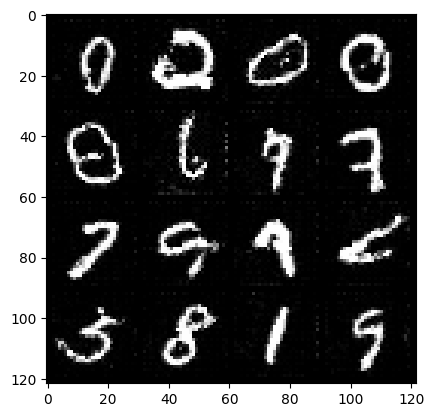

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 27 | D_loss: 0.6579376131232614 | G_loss: 0.7828157936840423


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 28 | D_loss: 0.6574818199631501 | G_loss: 0.7822374513408522


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 29 | D_loss: 0.6580890359909042 | G_loss: 0.7854635247797854


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 30 | D_loss: 0.65741502603234 | G_loss: 0.7852915863492596


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 31 | D_loss: 0.6576466955609922 | G_loss: 0.7863494507285324


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 32 | D_loss: 0.655557190812727 | G_loss: 0.7876148024347546


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 33 | D_loss: 0.655232208751158 | G_loss: 0.7904097591636023


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 34 | D_loss: 0.6534201045280327 | G_loss: 0.792159201366815


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 35 | D_loss: 0.6530483970001563 | G_loss: 0.7947892844041528


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 36 | D_loss: 0.6512496829795431 | G_loss: 0.7970565032603135


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 37 | D_loss: 0.6510440830482858 | G_loss: 0.8018184197482778


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 38 | D_loss: 0.6509864899649549 | G_loss: 0.8018718712619627


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 39 | D_loss: 0.6479909145501631 | G_loss: 0.8070636941934191


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 40 | D_loss: 0.645182362751666 | G_loss: 0.8102955356843944


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 41 | D_loss: 0.6447838623640634 | G_loss: 0.8168347814698209


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 42 | D_loss: 0.6433192935071266 | G_loss: 0.8195248013620438


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 43 | D_loss: 0.6413197593648297 | G_loss: 0.8215295233960345


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 44 | D_loss: 0.637005807367215 | G_loss: 0.829315899150458


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 45 | D_loss: 0.6362294038729881 | G_loss: 0.8353882330312912


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 46 | D_loss: 0.6339273548075385 | G_loss: 0.8422319591680824


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 47 | D_loss: 0.6312692052265728 | G_loss: 0.848914475837496


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 48 | D_loss: 0.6285993977904574 | G_loss: 0.8512147006703846


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 49 | D_loss: 0.6254525775594244 | G_loss: 0.8628521199419554


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24659099..1.0].


Epoch: 50 | D_loss: 0.6218536179711316 | G_loss: 0.8656385108860317


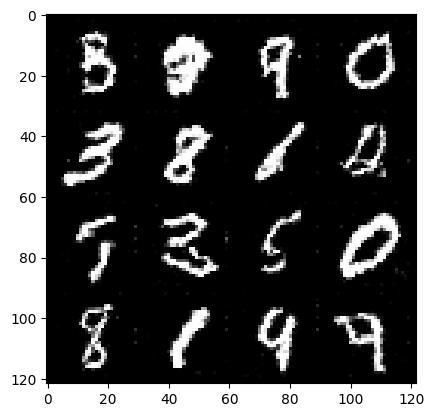

In [55]:
for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device = device)

        # find loss and update weights for D

        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss) / 2
        total_d_loss += D_loss.item()

        D_loss.backward()
        D_opt.step()

        # find loss and update weights for G

        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device = device)

        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

    if (i==0 or i==round(epochs/2) or i==epochs-1):
        show_tensor_images(fake_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30717644..1.0].


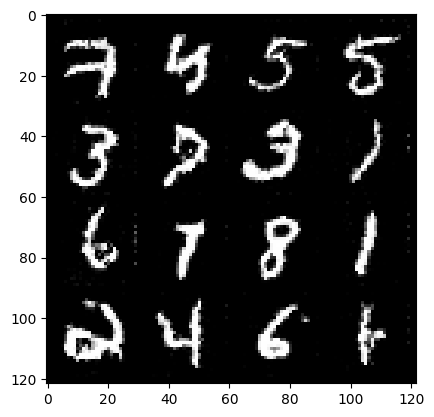

In [60]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25008875..1.0].


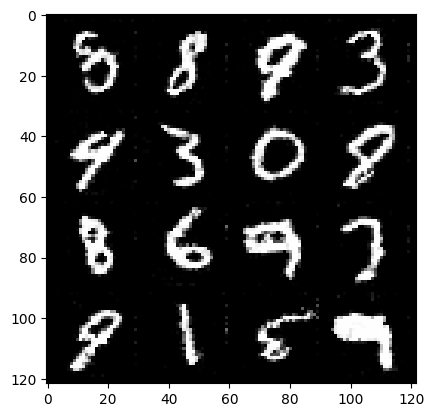

In [62]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

## Direct implementation of Gan model 

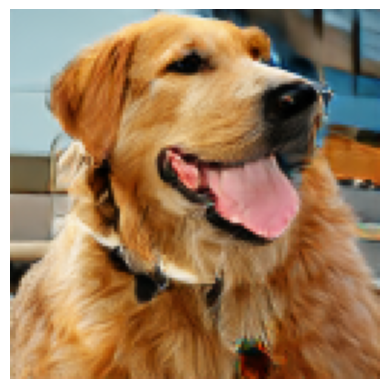

In [64]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

# Load BigGAN model
gan_model = hub.load("https://tfhub.dev/deepmind/biggan-deep-128/1")

# Create class vector for a specific class
def create_class_vector(class_id, batch_size=1, num_classes=1000):
    one_hot = np.zeros((batch_size, num_classes), dtype=np.float32)
    one_hot[:, class_id] = 1.0
    return tf.constant(one_hot)

# Generate random latent vector
def generate_latent_vector(batch_size=1, dim=128):
    return tf.random.normal([batch_size, dim])

# Generate image for specific class with adjustable truncation
def generate_image(class_id=207, truncation_value=0.8):
    noise = generate_latent_vector()
    class_vector = create_class_vector(class_id)
    truncation = tf.constant(truncation_value)
    output = gan_model.signatures['default'](truncation=truncation, y=class_vector, z=noise)["default"]
    img = (output[0] + 1.0) / 2.0
    return img

# Display image
def show_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage with truncation=0.8
generated_img = generate_image(class_id=207, truncation_value=0.8)
show_image(generated_img)
